In [1]:
%reload_ext autoreload
%autoreload 2

# Static potential: double well

In [2]:

#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 06/2023
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


import numpy as np
import matplotlib.pyplot as plt
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

import cvxpy as cx
from models.surface_trap import SurfaceTrap

from pathlib import Path
data_dir = Path('.').resolve() / 'data'

trap = SurfaceTrap()


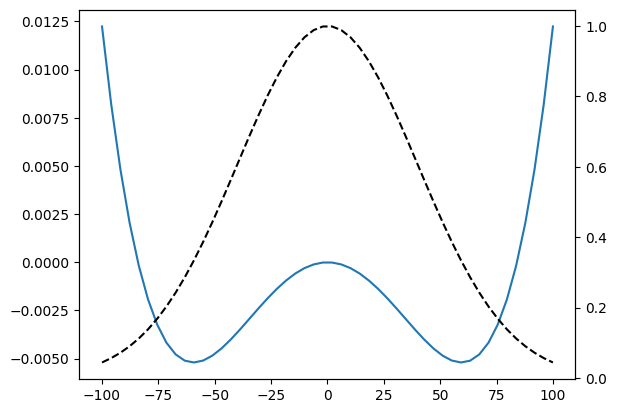

In [3]:

c2 = freq_to_curv(-0.6e6, ion=Ca40)
c4 = 1e16

n_samples = 1
ion = Ca40

L = 100e-6
x = np.linspace(-L, L, 50)
potential = 1/2 * c2 * x**2 + 1/24 * c4 * x**4
fit_sigma = 40e-6
fit_weight = np.exp(-x**2 / 2 / fit_sigma**2)

y0 = 0
z0 = trap.z0


fig, ax = plt.subplots()
ax.plot(x*1e6, potential)

ax2 = ax.twinx()
ax2.plot(x*1e6, fit_weight, 'k--')


In [4]:
e_top = [e for e in trap.electrodes if 'top' in e]
e_bot = [e.replace('top', 'bot') for e in e_top]

e_top, e_bot

(['DCintop', 'DCtop1', 'DCtop2', 'DCtop3', 'DCtop4', 'DCtop5'],
 ['DCinbot', 'DCbot1', 'DCbot2', 'DCbot3', 'DCbot4', 'DCbot5'])

In [29]:

waveform = init_waveform(n_samples, trap.n_electrodes)
offset = cx.Variable(name='offset')

objectives = [
    obj.PotentialObjective(waveform[0], trap, x, y0, z0, ion, value=potential + offset, pseudo=False, local_weights=fit_weight),
    obj.GradientObjective(waveform[0], trap, 0, y0, z0, ion, value=0, weight=1e3),
    obj.VoltageObjective(waveform, 25, constraint_type='<='),
    obj.VoltageObjective(waveform, -25, constraint_type='>='),
    obj.SymmetryObjective(waveform, e_top, e_bot, trap),
    obj.SymmetryObjective(waveform, 'DCtop1', 'DCtop5', trap),
    obj.SymmetryObjective(waveform, 'DCtop2', 'DCtop4', trap),
]

solver_results = solver(objectives, verbose=True, solver="ECOS", abstol=1e-8)
waveform = solver_results.waveform.value  # get array from cvxpy variable
offset = solver_results.variables['offset'].value

assert waveform is not None

savename = data_dir / 'waveform_double_well.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


Compiling objectives: 100%|██████████| 7/7 [00:00<00:00, 1289.82it/s]


                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 20 04:04:49 PM: Your problem has 13 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 20 04:04:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 20 04:04:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 20 04:04:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 20 04:04:49 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 20 04:04:49 PM: Compiling problem (target solver=ECOS).
(CVX

## Analysis

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout, plot_potential, plot3d_potential

from pytrans.ions import Ca40

trap = SurfaceTrap()
waveform = np.load(data_dir / 'waveform_double_well.npy')
voltages = waveform[0]

r0 = (0, 0, trap.z0)
roi = (L, 10e-6, 10e-6)

res = analyse_potential(trap, voltages, ions=[Ca40] * 2, ion1=Ca40,
                        r0=r0, roi=roi, find_3dmin=False, verbose=False, plot=False)

res


--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[ 0.     0.    67.082]
Gradient [V/m]
[0. 0. 0.]
Displacement at 1 MHz [um]
[0. 0. 0.]
Hessian [V/m2]
[[-4.1751e+06 -2.2455e-05 -2.7565e-05]
 [-2.2455e-05  6.4359e+08  1.2238e-06]
 [-2.7565e-05  1.2238e-06  5.6947e+08]]
Normal mode frequencies [MHz]
[-0.505307 5.90148 6.27379]
Eigenvectors
[[1 3.47e-14 4.81e-14]
 [-4.81e-14 -1.79e-14 1]
 [3.47e-14 -1 -1.77e-14]]
Tilt angle of mode 2 (6.27): -180.00°
--------------
Mode solver analysis for ion crystal [Ca40, Ca40]: 
Equilibrium positions [um]
[[-59.0638  -0.      66.9327]
 [ 59.064   -0.      66.9327]]
Normal modes
  Freq [MHz]                    Ca40                               Ca40
------------  ----------  ----------  ---------  ----------  ----------  ----------
      0.6543   0.7133      1.316e-09  0.003741    0.7008     -6.836e-09  -0.003676
      0.6545   0.7008      1.294e-09  0.003676   -0.7133      6.956e-09   0.003741
      5.981   -0.002745   -

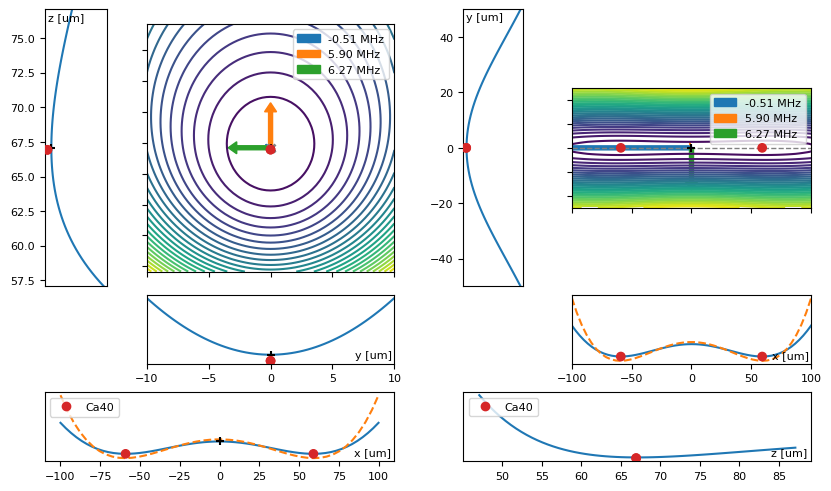

In [31]:

fig, axes = plot_potential_make_layout(2)
roi1 = (100e-6, 10e-6, 10e-6)
_ = plot_potential(trap, voltages, Ca40, r0, roi1, trap_axis='x', axes=axes[0], analyse_results=res)
axes[0][0].plot(x*1e6, potential + offset, '--')

roi1 = (100e-6, 50e-6, 20e-6)
_ = plot_potential(trap, voltages, Ca40, r0, roi1, trap_axis='z', axes=axes[1], analyse_results=res)
axes[1][1].plot(x*1e6, potential + offset, '--')


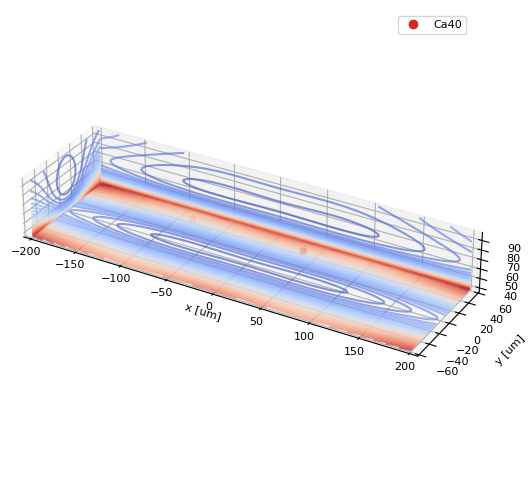

In [32]:

roi1 = (200e-6, 60e-6, 30e-6)
_ = plot3d_potential(trap, voltages, Ca40, r0, roi1, analyse_results=res)


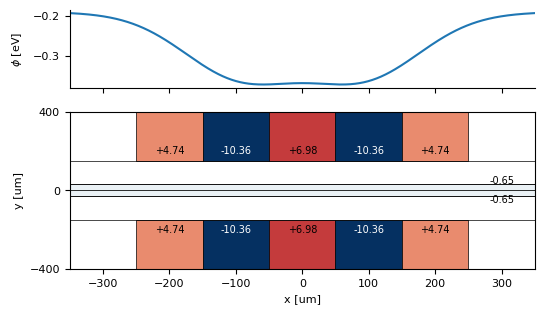

In [33]:

_ = plot_voltages_on_trap(trap, waveform[0])
